In [19]:
%matplotlib notebook
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np

from halotools.empirical_models import PrebuiltHodModelFactory
from halotools.sim_manager import CachedHaloCatalog
from halotools import sim_manager
from halotools.mock_observables import return_xyz_formatted_array
from halotools.mock_observables import wp


In [ ]:
from halotools.mock_observables import wp


In [ ]:
# might need this:
import halotools.sim_manager.sim_defaults as sim_defaults
sim_defaults.default_simname = 'multidark'

In [ ]:
# Download halo catalogs (only needs to be done once)
from halotools.sim_manager import DownloadManager
dman = DownloadManager()
dman.download_processed_halo_table('multidark', 'rockstar', 1.0) 

In [2]:
# default_halocat = sim_manager.CachedHaloCatalog() 
# zheng07_model = PrebuiltHodModelFactory('zheng07', threshold = -19.5, redshift = 0.0)
zheng07_model = PrebuiltHodModelFactory('zheng07', redshift = 1.0004)
# halocat = CachedHaloCatalog(simname = 'bolshoi', redshift = 0.0, halo_finder = 'rockstar')
halocat = CachedHaloCatalog(simname = 'multidark', halo_finder = 'rockstar', \
                            version_name = 'halotools_v0p4', redshift = 1.0004)
zheng07_model.populate_mock(halocat)

# sample
# zheng07_model.mock.galaxy_table[3]

/home/tjr63/miniconda3/envs/halotools_env/lib/python3.7/site-packages/halotools/empirical_models/phase_space_models/analytic_models/monte_carlo_helpers.py:205: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  self.rad_prof_func_table_indices[digitized_param_list]
/home/tjr63/miniconda3/envs/halotools_env/lib/python3.7/site-packages/halotools/empirical_models/phase_space_models/analytic_models/monte_carlo_helpers.py:522: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  self.rad_prof_func_table_indices[digitized_param_list]


In [ ]:
rr, xi_cc, xi_cs, xi_ss = zheng07_model.compute_average_galaxy_clustering(\
                            gal_type = 'centrals', include_crosscorr = True, \
                            num_iterations = 3, num_threads = 'max') 

In [5]:
# https://halotools.readthedocs.io/en/latest/api/halotools.empirical_models.ModelFactory.html#halotools.empirical_models.ModelFactory.compute_average_galaxy_clustering
# "The compute_average_galaxy_clustering is simply a convenience function, and is not intended for use in performance-critical applications such as MCMCs"
r, xi_gg = zheng07_model.compute_average_galaxy_clustering(rbins=rbins, simname='multidark')

/home/tjr63/miniconda3/envs/halotools_env/lib/python3.7/site-packages/halotools/empirical_models/phase_space_models/analytic_models/monte_carlo_helpers.py:205: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  self.rad_prof_func_table_indices[digitized_param_list]
/home/tjr63/miniconda3/envs/halotools_env/lib/python3.7/site-packages/halotools/empirical_models/phase_space_models/analytic_models/monte_carlo_helpers.py:522: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  self.rad_prof_func_table_indices[digitized_param_list]
/home/tjr63/miniconda3

<IPython.core.display.Javascript object>


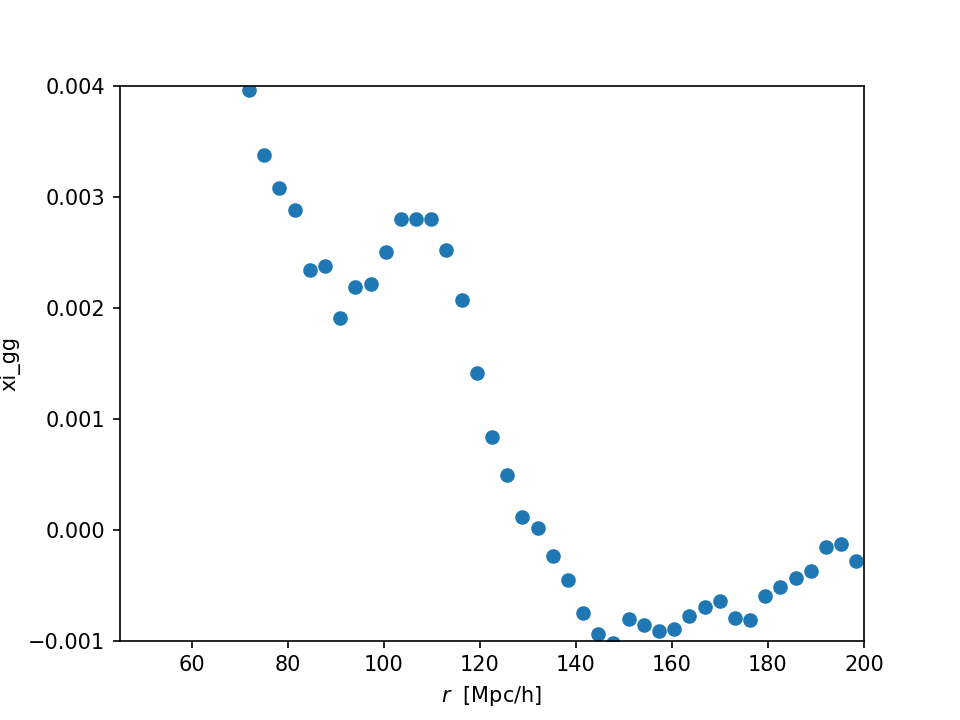

In [8]:
# Plot 3D correlation function

plt.figure()
plt.scatter(r,xi_gg)
# plt.loglog()
plt.axis([45,200, -0.001,0.004])
plt.xlabel(r'$r $  $\rm{[Mpc/h]}$')
plt.ylabel('xi_gg')
plt.show()

In [ ]:
pos

In [20]:
rbins = np.linspace(45,200, num=50)
rp_bins = np.logspace(-1,1.25,15)


In [21]:
# 2D correlation funciton, w_p
# following- https://halotools.readthedocs.io/en/latest/quickstart_and_tutorials/tutorials/catalog_analysis/galcat_analysis/basic_examples/clustering_examples/galaxy_catalog_analysis_tutorial4.html#galaxy-catalog-analysis-tutorial4
# and- https://halotools.readthedocs.io/en/latest/api/halotools.mock_observables.wp.html#halotools.mock_observables.wp
x = zheng07_model.mock.galaxy_table['x']
y = zheng07_model.mock.galaxy_table['y']
z = zheng07_model.mock.galaxy_table['z']
pos = return_xyz_formatted_array(x, y, z)


pi_max = 40.

w_p = wp(pos, rbins, pi_max, period=zheng07_model.mock.Lbox, num_threads='max')

<IPython.core.display.Javascript object>


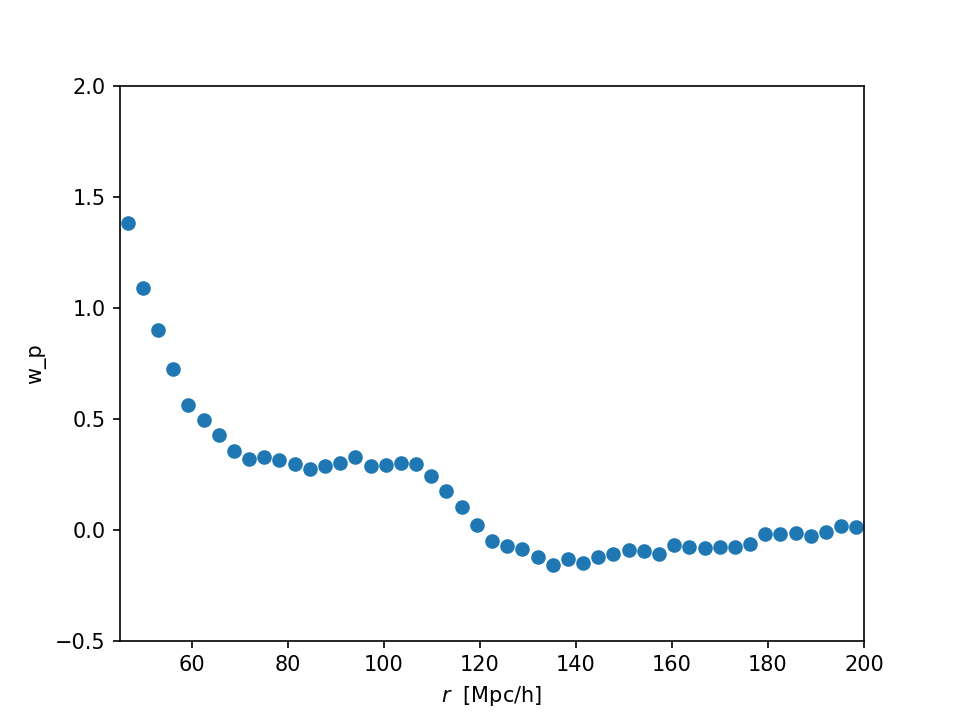

In [45]:
# Plot w_p
rp_bin_centers = (rbins[:-1] + rbins[1:])/2.

plt.figure()
plt.scatter(rp_bin_centers, w_p)
plt.axis([45,200, -0.5,2])
plt.xlabel(r'$r $  $\rm{[Mpc/h]}$')
plt.ylabel('w_p')
plt.show()

In [36]:
rp_bin_centers = (rbins[:-1] + rbins[1:])/2.
rbins[:-1]

array([ 45.        ,  48.16326531,  51.32653061,  54.48979592,
        57.65306122,  60.81632653,  63.97959184,  67.14285714,
        70.30612245,  73.46938776,  76.63265306,  79.79591837,
        82.95918367,  86.12244898,  89.28571429,  92.44897959,
        95.6122449 ,  98.7755102 , 101.93877551, 105.10204082,
       108.26530612, 111.42857143, 114.59183673, 117.75510204,
       120.91836735, 124.08163265, 127.24489796, 130.40816327,
       133.57142857, 136.73469388, 139.89795918, 143.06122449,
       146.2244898 , 149.3877551 , 152.55102041, 155.71428571,
       158.87755102, 162.04081633, 165.20408163, 168.36734694,
       171.53061224, 174.69387755, 177.85714286, 181.02040816,
       184.18367347, 187.34693878, 190.51020408, 193.67346939,
       196.83673469])

In [37]:
rp_bin_centers

array([ 46.58163265,  49.74489796,  52.90816327,  56.07142857,
        59.23469388,  62.39795918,  65.56122449,  68.7244898 ,
        71.8877551 ,  75.05102041,  78.21428571,  81.37755102,
        84.54081633,  87.70408163,  90.86734694,  94.03061224,
        97.19387755, 100.35714286, 103.52040816, 106.68367347,
       109.84693878, 113.01020408, 116.17346939, 119.33673469,
       122.5       , 125.66326531, 128.82653061, 131.98979592,
       135.15306122, 138.31632653, 141.47959184, 144.64285714,
       147.80612245, 150.96938776, 154.13265306, 157.29591837,
       160.45918367, 163.62244898, 166.78571429, 169.94897959,
       173.1122449 , 176.2755102 , 179.43877551, 182.60204082,
       185.76530612, 188.92857143, 192.09183673, 195.25510204,
       198.41836735])

In [ ]:
?zheng07_model.compute_average_galaxy_clustering

In [ ]:
?PrebuiltHodModelFactory